# Computer Vision - Phân loại phương tiện giao thông đường bộ Việt Nam

## Mục tiêu:
- Huấn luyện/Fine-tune EfficientNet và ResNet cho bài toán phân loại ảnh phương tiện giao thông đường bộ
- Tiền xử lý dữ liệu: đưa tất cả ảnh về cùng kích thước (Resize)
- Áp dụng Transfer Learning, Data Augmentation, Learning Rate Scheduling
- (Tuỳ chọn) Ensembling và Test-Time Augmentation (TTA) để tối ưu

## Dataset (thư mục theo lớp)
Notebook này giả định dữ liệu của bạn được tổ chức theo cấu trúc:

```
DATA_DIR/
  Bicycle/
    img1.jpg
    ...
  Bus-Coach/
    ...
  Car/
    ...
  Motorbike/
    ...
  Truck/
    ...
  Others/
    ...
```

Tên lớp sẽ được lấy tự động từ tên folder con trong `DATA_DIR`.

## 1. Environment Setup and Imports

In [1]:
# =========================
# 1) Environment Setup (Google Colab)
# =========================
# Cài package cần thiết (Colab)
!pip -q install timm

import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
import timm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Device setup (Colab)
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('✅ CUDA is available!')
        print(f'🔥 GPU: {torch.cuda.get_device_name(0)}')
        print(f'💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
        torch.cuda.empty_cache()
        gc.collect()
        # Speed: enable benchmark when input size is fixed (we resize to IMG_SIZE)
        torch.backends.cudnn.benchmark = True
    else:
        device = torch.device('cpu')
        print('⚠️ CUDA not available, using CPU')
        print('💡 Colab: Runtime → Change runtime type → GPU')
    return device

device = setup_device()

✅ CUDA is available!
🔥 GPU: Tesla T4
💾 GPU Memory: 14.7 GB


In [2]:
# =========================
# Colab environment check (optional)
# =========================
def check_colab_environment():
    is_colab = False
    try:
        import google.colab  # type: ignore
        is_colab = True
    except Exception:
        is_colab = False

    if is_colab:
        print('🏁 Running on Google Colab')
        # Hiển thị thư mục làm việc
        print(f'📁 Working directory: {os.getcwd()}')
    else:
        print('💻 Not running on Google Colab (local/Jupyter)')

    return is_colab

is_colab = check_colab_environment()

🏁 Running on Google Colab
📁 Working directory: /content


## 2. Data Loading and Visualization

In [3]:
# =========================
# DATASET LOADING (GOOGLE DRIVE / COLAB)
# =========================
from torchvision.datasets import ImageFolder
from collections import Counter
import os

# Mount Google Drive nếu đang chạy trên Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('✅ Mounted Google Drive at /content/drive')
except Exception:
    # Không phải Colab hoặc đã mount sẵn
    pass

# TODO: SỬA đường dẫn này tới folder chứa các folder lớp (trên Google Drive)
DATA_DIR = "/content/drive/MyDrive/Dataset TGMT/Final_2000"

assert os.path.isdir(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"

# Load dataset thô (chưa transform) để có thể áp transform linh hoạt cho train/val/test
base_dataset = ImageFolder(root=DATA_DIR, transform=None)
CLASS_NAMES = base_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

print(f"📁 DATA_DIR: {DATA_DIR}")
print(f"✅ Found {len(base_dataset)} images")
print(f"✅ Found {NUM_CLASSES} classes: {CLASS_NAMES}")

# (Tuỳ chọn) thống kê số ảnh theo lớp
counts = Counter(base_dataset.targets)
for class_idx, class_name in enumerate(CLASS_NAMES):
    print(f"- {class_name}: {counts.get(class_idx, 0)}")

Mounted at /content/drive
✅ Mounted Google Drive at /content/drive
📁 DATA_DIR: /content/drive/MyDrive/Dataset TGMT/Final_2000
✅ Found 1994 images
✅ Found 6 classes: ['Bicycle_350', 'Bus Coach_350', 'Car_375', 'Motorbike_345', 'Others_255', 'Truck_325']
- Bicycle_350: 350
- Bus Coach_350: 350
- Car_375: 370
- Motorbike_345: 345
- Others_255: 255
- Truck_325: 324


In [4]:
# Visualization function (works with normalized tensors)
def visualize_samples(dataset, classes, num_samples=20):
    """Visualize random samples from a dataset that returns (tensor, label)."""
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    mean = torch.tensor([0.485, 0.456, 0.406])  # ImageNet mean
    std = torch.tensor([0.229, 0.224, 0.225])   # ImageNet std

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Denormalize for visualization
        image = image.detach().cpu()
        image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)
        image = torch.clamp(image, 0, 1)

        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"{classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

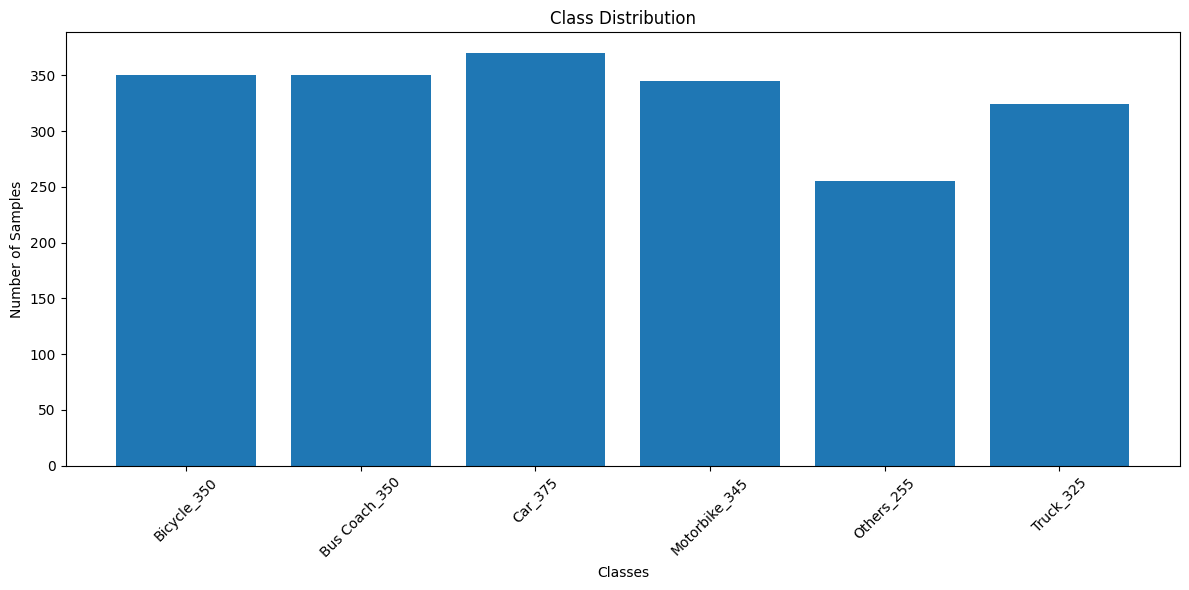

Class distribution: {'Bicycle_350': np.int64(350), 'Bus Coach_350': np.int64(350), 'Car_375': np.int64(370), 'Motorbike_345': np.int64(345), 'Others_255': np.int64(255), 'Truck_325': np.int64(324)}


In [5]:
# Class distribution analysis
def analyze_class_distribution(labels, classes):
    """Analyze and visualize class distribution from label list."""
    unique, counts = np.unique(np.array(labels), return_counts=True)

    plt.figure(figsize=(12, 6))
    plt.bar([classes[i] for i in unique], counts)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return dict(zip([classes[i] for i in unique], counts))

class_dist = analyze_class_distribution(base_dataset.targets, CLASS_NAMES)
print("Class distribution:", class_dist)

## 3. Data Augmentation and Custom Dataset

In [6]:
# =========================
# PREPROCESSING + RESIZE (đưa ảnh về cùng kích thước)
# =========================
IMG_SIZE = 224  # phổ biến cho pretrained EfficientNet/ResNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# Dataset wrapper: lấy ảnh PIL từ base_dataset (transform=None) rồi áp transform tương ứng
class TransformSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]  # img là PIL.Image
        if self.transform is not None:
            img = self.transform(img)
        return img, label

print(f"🖼️  All images will be resized to: {IMG_SIZE}x{IMG_SIZE}")

🖼️  All images will be resized to: 224x224


Split sizes -> train: 1595, val: 199, test: 200
📊 Config: Batch size = 32, Workers = 4


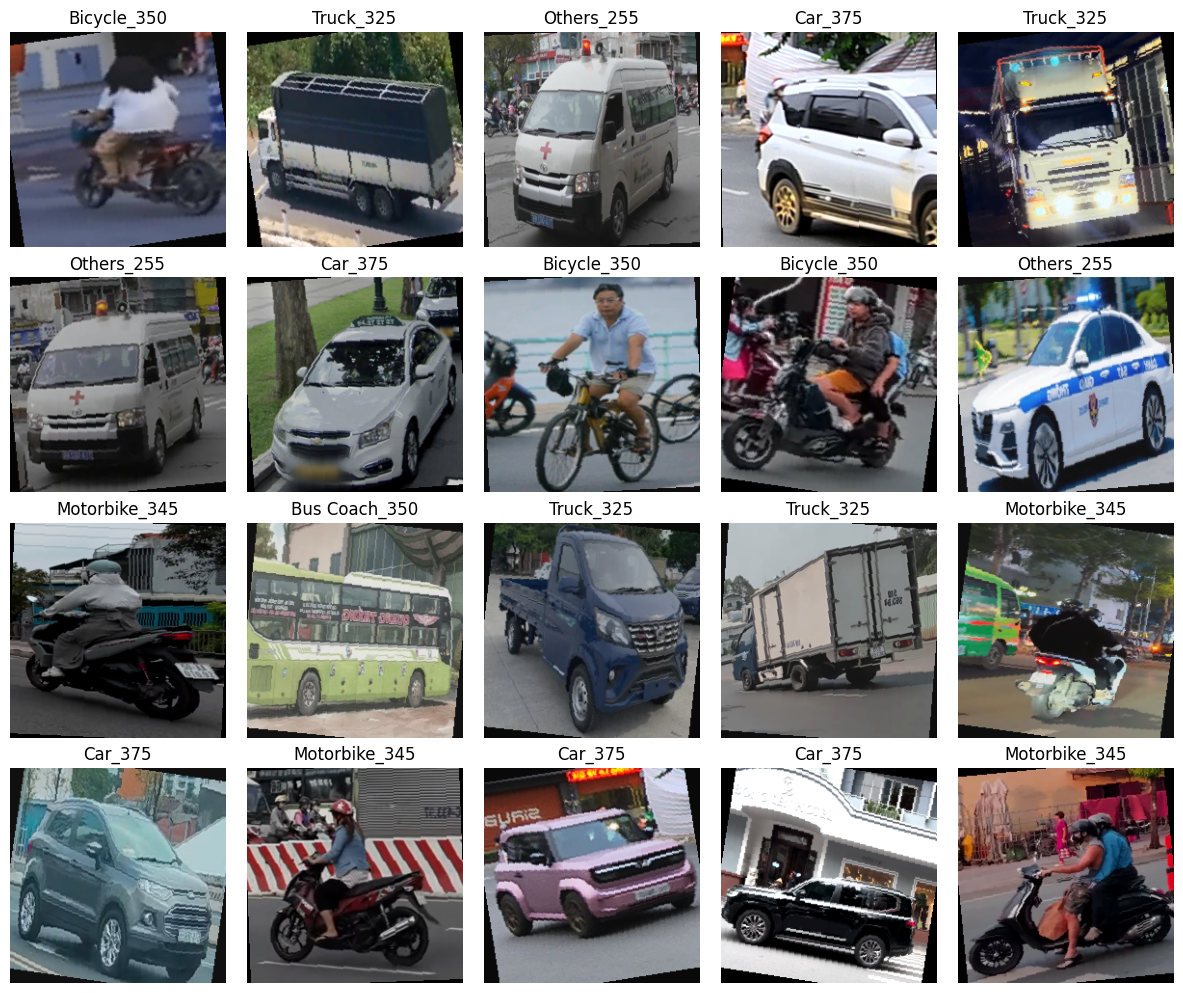

In [7]:
# =========================
# TRANSFORMS + TRAIN/VAL/TEST SPLIT + DATALOADERS
# =========================
from torchvision import transforms

# Train augmentation (nhẹ, an toàn) + Resize về cùng kích thước
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Val/Test: chỉ Resize + Normalize
eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# TTA transforms (giữ deterministic)
tta_transforms = [
    eval_transform,
    transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
 ]

# Split train/val/test (nếu bạn chưa tách sẵn theo folder)
seed = 42
g = torch.Generator().manual_seed(seed)
num_total = len(base_dataset)
train_size = int(0.8 * num_total)
val_size = int(0.1 * num_total)
test_size = num_total - train_size - val_size

perm = torch.randperm(num_total, generator=g).tolist()
train_idx = perm[:train_size]
val_idx = perm[train_size:train_size + val_size]
test_idx = perm[train_size + val_size:]

train_dataset = TransformSubset(base_dataset, train_idx, train_transform)
val_dataset = TransformSubset(base_dataset, val_idx, eval_transform)
test_dataset = TransformSubset(base_dataset, test_idx, eval_transform)

print(f"Split sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

# Tối ưu DataLoader (giữ logic của bạn, nhưng phù hợp local/Kaggle)
def get_optimal_config():
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        if gpu_memory >= 15:
            batch_size = 64
            num_workers = 4
        elif gpu_memory >= 12:
            batch_size = 32
            num_workers = 4
        else:
            batch_size = 16
            num_workers = 2
    else:
        batch_size = 8
        num_workers = 2
    return batch_size, num_workers

BATCH_SIZE, NUM_WORKERS = get_optimal_config()
print(f"📊 Config: Batch size = {BATCH_SIZE}, Workers = {NUM_WORKERS}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

# Visualize vài ảnh sau transform để kiểm tra Resize/Normalize
visualize_samples(train_dataset, CLASS_NAMES, num_samples=20)

## 4. Model Architecture - EfficientNet and ResNet

In [8]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=10, pretrained=True):
        super(CIFAR10Classifier, self).__init__()
        self.model_name = model_name

        # Load pretrained model
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        # Get the number of features from the backbone
        if hasattr(self.backbone, 'classifier'):
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif hasattr(self.backbone, 'fc'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif hasattr(self.backbone, 'head'):
            in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        else:
            raise ValueError(f"Unsupported backbone head for model: {model_name}")

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Create models
def create_model(model_name, num_classes):
    model = CIFAR10Classifier(model_name=model_name, num_classes=num_classes)
    return model.to(device)

# Initialize models (num_classes lấy theo dataset của bạn)
efficientnet_model = create_model('efficientnet_b0', NUM_CLASSES)
resnet_model = create_model('resnet50', NUM_CLASSES)

print(f"Classes: {NUM_CLASSES}")
print(f"EfficientNet parameters: {sum(p.numel() for p in efficientnet_model.parameters()):,}")
print(f"ResNet parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Classes: 6
EfficientNet parameters: 4,666,498
ResNet parameters: 24,560,198


## 5. Training Setup and Learning Rate Scheduling

In [9]:
# =========================
# TRAINING SETUP (dùng lại model/loader đã tạo ở trên)
# =========================

# Enhanced training configuration
class TrainingConfig:
    def __init__(self):
        self.epochs = 5
        self.learning_rate = 1e-3
        self.weight_decay = 1e-4
        self.patience = 10
        self.min_lr = 1e-6
        self.use_amp = True  # Automatic Mixed Precision
        self.gradient_clip = 1.0
        self.accumulation_steps = 1

config = TrainingConfig()

def clear_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def print_memory_usage():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f'💾 GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB')

def train_model(model, train_loader, val_loader, config, model_name):
    """Train a model with AMP, LR scheduling and early stopping."""
    from torch.cuda.amp import autocast, GradScaler

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        eps=1e-8,
    )

    scaler = GradScaler() if (config.use_amp and torch.cuda.is_available()) else None

    clear_memory()
    print_memory_usage()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=config.min_lr
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_acc = 0.0
    patience_counter = 0

    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')
        optimizer.zero_grad(set_to_none=True)
        for batch_idx, (data, target) in enumerate(train_pbar):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            if scaler is not None:
                with autocast():
                    output = model(data)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()

                if (batch_idx + 1) % config.accumulation_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
            else:
                output = model(data)
                loss = criterion(output, target)
                loss.backward()

                if (batch_idx + 1) % config.accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                    optimizer.step()
                    optimizer.zero_grad(set_to_none=True)

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        train_loss_avg = train_loss / max(1, len(train_loader))
        train_acc = 100. * train_correct / max(1, train_total)
        val_loss_avg = val_loss / max(1, len(val_loader))
        val_acc = 100. * val_correct / max(1, val_total)

        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            patience_counter += 1

        print(
            f'Epoch {epoch+1}: Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%, '
            f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%, LR: {optimizer.param_groups[0]["lr"]:.6f}'
        )

        if patience_counter >= config.patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model weights if saved
    try:
        model.load_state_dict(torch.load(f'best_{model_name}.pth', map_location=device))
    except Exception as e:
        print(f'⚠️ Could not reload best weights: {e}')

    return model, history, best_acc

## 6. Train Models

In [10]:
# Train EfficientNet (dùng val_loader làm validation)
print("Training EfficientNet...")
efficientnet_trained, efficientnet_history, efficientnet_best_acc = train_model(
    efficientnet_model, train_loader, val_loader, config, 'efficientnet'
)

print(f"\nEfficientNet Best Val Accuracy: {efficientnet_best_acc:.2f}%")

Training EfficientNet...
💾 GPU Memory - Allocated: 0.11GB, Cached: 0.13GB


Epoch 1/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.9611, Train Acc: 76.68%, Val Loss: 0.6961, Val Acc: 88.94%, LR: 0.001000


Epoch 2/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6176, Train Acc: 93.04%, Val Loss: 0.6055, Val Acc: 90.95%, LR: 0.001000


Epoch 3/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.5437, Train Acc: 95.42%, Val Loss: 0.6943, Val Acc: 86.93%, LR: 0.001000


Epoch 4/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5300, Train Acc: 96.05%, Val Loss: 0.7495, Val Acc: 85.93%, LR: 0.001000


Epoch 5/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.5193, Train Acc: 96.24%, Val Loss: 0.6184, Val Acc: 91.46%, LR: 0.001000

EfficientNet Best Val Accuracy: 91.46%


In [11]:
# Train ResNet (dùng val_loader làm validation)
print("Training ResNet...")
resnet_trained, resnet_history, resnet_best_acc = train_model(
    resnet_model, train_loader, val_loader, config, 'resnet'
)

print(f"\nResNet Best Val Accuracy: {resnet_best_acc:.2f}%")

Training ResNet...
💾 GPU Memory - Allocated: 0.13GB, Cached: 0.17GB


Epoch 1/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.0352, Train Acc: 70.66%, Val Loss: 0.8296, Val Acc: 83.42%, LR: 0.001000


Epoch 2/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6205, Train Acc: 91.60%, Val Loss: 0.6632, Val Acc: 88.94%, LR: 0.001000


Epoch 3/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.5462, Train Acc: 95.05%, Val Loss: 0.6483, Val Acc: 88.94%, LR: 0.001000


Epoch 4/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5094, Train Acc: 97.30%, Val Loss: 0.5983, Val Acc: 91.96%, LR: 0.001000


Epoch 5/5 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.4982, Train Acc: 97.62%, Val Loss: 0.6232, Val Acc: 90.95%, LR: 0.001000

ResNet Best Val Accuracy: 91.96%


## 7. Training Visualization and Analysis

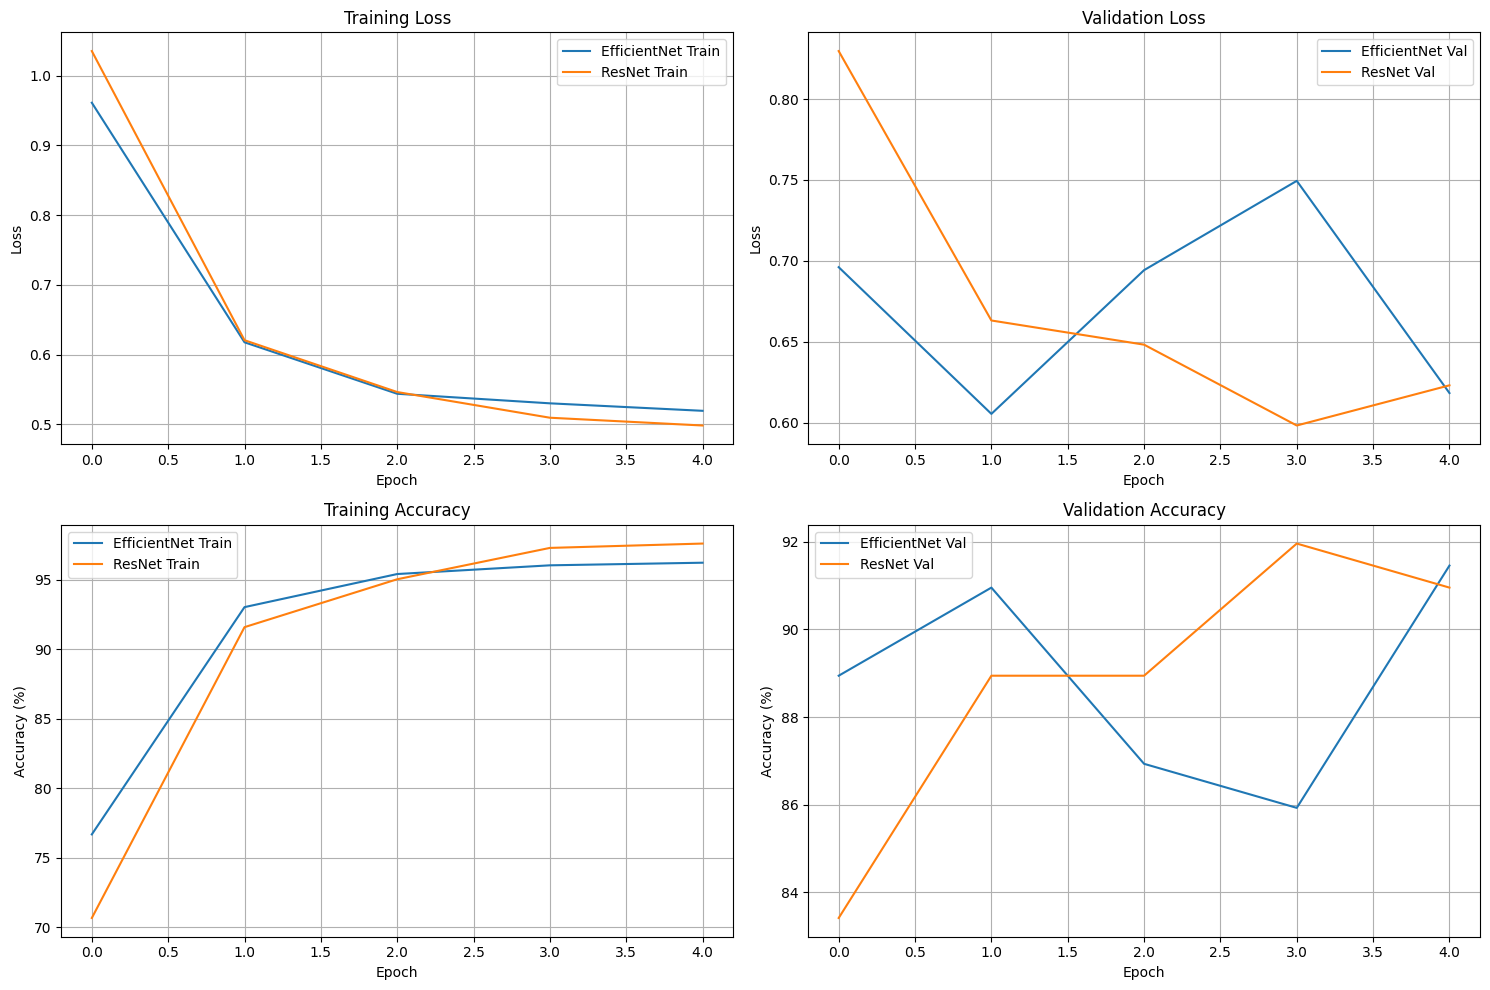

In [12]:
# Plot training history
def plot_training_history(histories, model_names):
    """Plot training history for multiple models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plots
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 0].plot(history['train_loss'], label=f'{name} Train')
        axes[0, 1].plot(history['val_loss'], label=f'{name} Val')
        axes[1, 0].plot(history['train_acc'], label=f'{name} Train')
        axes[1, 1].plot(history['val_acc'], label=f'{name} Val')

    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot histories
plot_training_history(
    [efficientnet_history, resnet_history],
    ['EfficientNet', 'ResNet']
)

## 8. Model Evaluation and Error Analysis

In [13]:
# Evaluation function
def evaluate_model(model, loader, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in tqdm(loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            _, predicted = output.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_targets, all_preds)
    return accuracy, report, cm, np.array(all_probs), np.array(all_targets), np.array(all_preds)

# Evaluate both models on TEST set
print("Evaluating EfficientNet (test set)...")
eff_acc, eff_report, eff_cm, eff_probs, targets, eff_preds = evaluate_model(
    efficientnet_trained, test_loader, CLASS_NAMES
)

print("Evaluating ResNet (test set)...")
res_acc, res_report, res_cm, res_probs, _, res_preds = evaluate_model(
    resnet_trained, test_loader, CLASS_NAMES
)

print("\nFinal Results (Test):")
print(f"EfficientNet Accuracy: {eff_acc:.4f}")
print(f"ResNet Accuracy: {res_acc:.4f}")

Evaluating EfficientNet (test set)...


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating ResNet (test set)...


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


Final Results (Test):
EfficientNet Accuracy: 0.9600
ResNet Accuracy: 0.9400


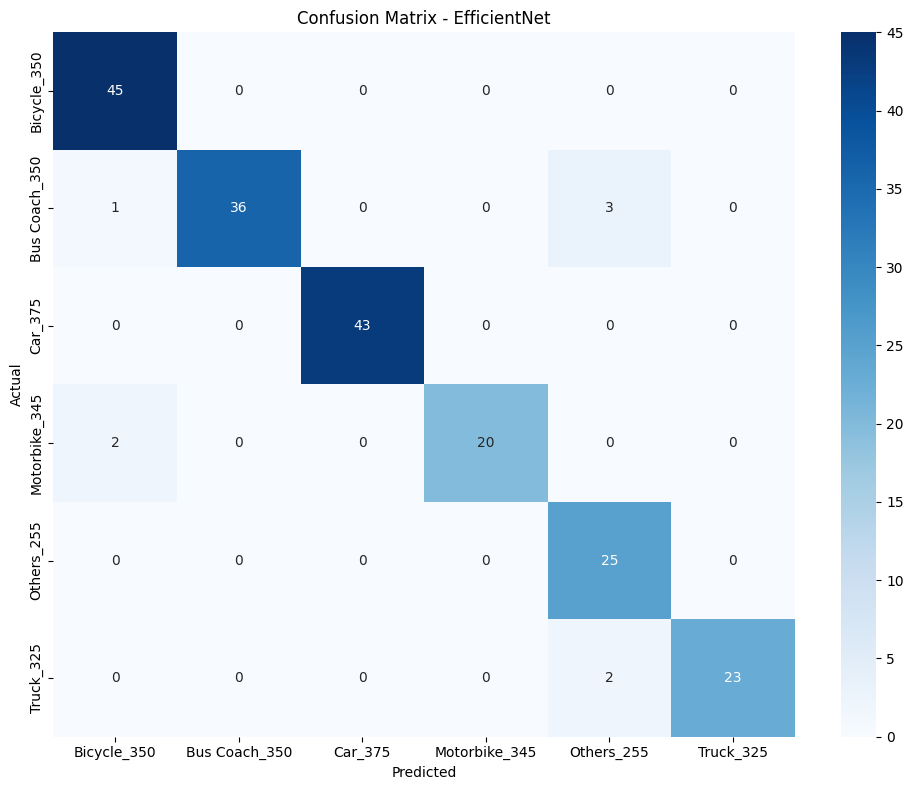

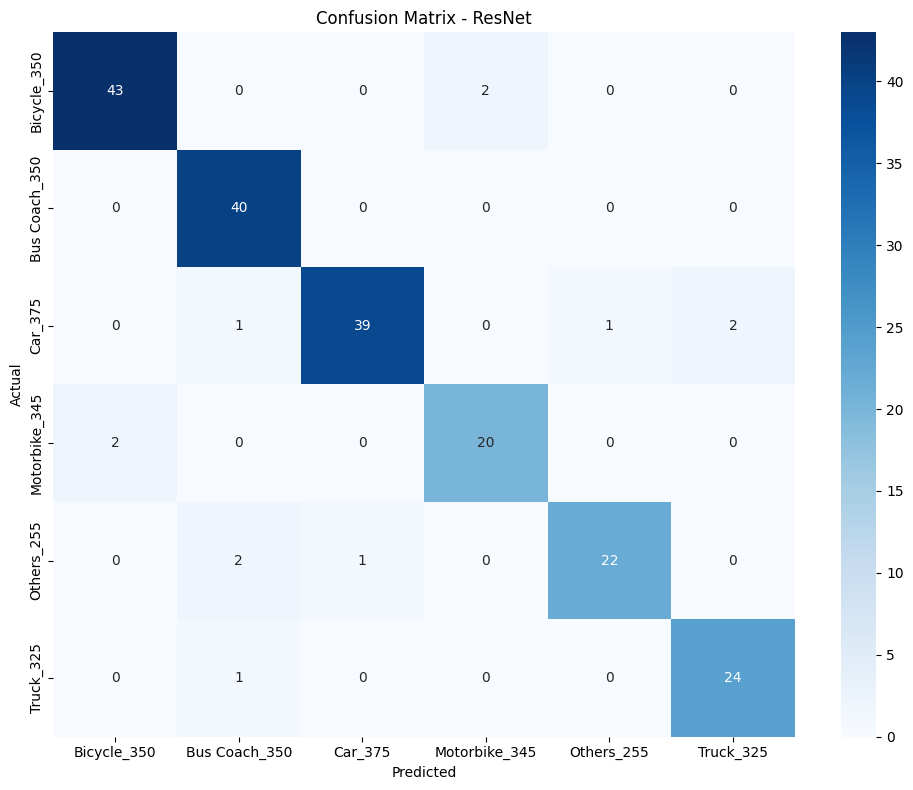

In [14]:
# Visualize confusion matrices
def plot_confusion_matrix(cm, class_names, title):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(eff_cm, CLASS_NAMES, 'EfficientNet')
plot_confusion_matrix(res_cm, CLASS_NAMES, 'ResNet')

## 9. Ensembling and Test-Time Augmentation (TTA)

In [15]:
# Test-Time Augmentation (TTA) for folder dataset
def predict_probs(model, loader):
    model.eval()
    probs_all = []
    with torch.no_grad():
        for data, _ in tqdm(loader, desc='Predicting'):
            data = data.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            probs_all.append(probs.cpu().numpy())
    return np.vstack(probs_all)

def predict_with_tta(model, base_dataset, indices, tta_transforms, batch_size, num_workers):
    """Predict with TTA by averaging probabilities across transforms."""
    all_probs = []
    for k, tfm in enumerate(tta_transforms, start=1):
        ds = TransformSubset(base_dataset, indices, tfm)
        loader = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            persistent_workers=True if num_workers > 0 else False,
        )
        probs = predict_probs(model, loader)
        all_probs.append(probs)
    return np.mean(all_probs, axis=0)

# Ground-truth labels for test split
y_test = np.array([base_dataset.targets[i] for i in test_idx])

print("Applying TTA to EfficientNet...")
eff_tta_probs = predict_with_tta(
    efficientnet_trained, base_dataset, test_idx, tta_transforms, BATCH_SIZE, NUM_WORKERS
)

print("Applying TTA to ResNet...")
res_tta_probs = predict_with_tta(
    resnet_trained, base_dataset, test_idx, tta_transforms, BATCH_SIZE, NUM_WORKERS
)

# Calculate TTA accuracies
eff_tta_preds = np.argmax(eff_tta_probs, axis=1)
res_tta_preds = np.argmax(res_tta_probs, axis=1)

eff_tta_acc = accuracy_score(y_test, eff_tta_preds)
res_tta_acc = accuracy_score(y_test, res_tta_preds)

print("\nTTA Results (Test):")
print(f"EfficientNet TTA Accuracy: {eff_tta_acc:.4f} (Improvement: {eff_tta_acc - eff_acc:.4f})")
print(f"ResNet TTA Accuracy: {res_tta_acc:.4f} (Improvement: {res_tta_acc - res_acc:.4f})")

Applying TTA to EfficientNet...


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Applying TTA to ResNet...


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]


TTA Results (Test):
EfficientNet TTA Accuracy: 0.9600 (Improvement: 0.0000)
ResNet TTA Accuracy: 0.9350 (Improvement: -0.0050)


In [16]:
# Ensemble methods
def ensemble_predictions(predictions_list, method='average'):
    """Ensemble multiple model predictions (probabilities)."""
    if method == 'average':
        return np.mean(predictions_list, axis=0)
    elif method == 'weighted':
        weights = np.array([eff_tta_acc, res_tta_acc], dtype=np.float64)
        weights = weights / weights.sum()
        return np.average(predictions_list, axis=0, weights=weights)
    elif method == 'voting':
        preds = [np.argmax(pred, axis=1) for pred in predictions_list]
        ensemble_preds = []
        for i in range(len(preds[0])):
            votes = [pred[i] for pred in preds]
            ensemble_preds.append(max(set(votes), key=votes.count))
        return np.array(ensemble_preds)
    else:
        raise ValueError(f"Unknown method: {method}")

ensemble_probs_avg = ensemble_predictions([eff_tta_probs, res_tta_probs], 'average')
ensemble_probs_weighted = ensemble_predictions([eff_tta_probs, res_tta_probs], 'weighted')
ensemble_preds_voting = ensemble_predictions([eff_tta_probs, res_tta_probs], 'voting')

ensemble_acc_avg = accuracy_score(y_test, np.argmax(ensemble_probs_avg, axis=1))
ensemble_acc_weighted = accuracy_score(y_test, np.argmax(ensemble_probs_weighted, axis=1))
ensemble_acc_voting = accuracy_score(y_test, ensemble_preds_voting)

print("\nEnsemble Results (Test):")
print(f"Average Ensemble Accuracy: {ensemble_acc_avg:.4f}")
print(f"Weighted Ensemble Accuracy: {ensemble_acc_weighted:.4f}")
print(f"Voting Ensemble Accuracy: {ensemble_acc_voting:.4f}")


Ensemble Results (Test):
Average Ensemble Accuracy: 0.9950
Weighted Ensemble Accuracy: 0.9950
Voting Ensemble Accuracy: 0.9500


## 10. Final Results Summary and Submission

In [17]:
# Create comprehensive results summary
results_summary = {
    'Model': ['EfficientNet', 'ResNet', 'EfficientNet + TTA', 'ResNet + TTA',
              'Average Ensemble', 'Weighted Ensemble', 'Voting Ensemble'],
    'Accuracy': [eff_acc, res_acc, eff_tta_acc, res_tta_acc,
                ensemble_acc_avg, ensemble_acc_weighted, ensemble_acc_voting]
}

results_df = pd.DataFrame(results_summary)
results_df['Accuracy'] = results_df['Accuracy'].round(4)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY (TEST)")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)

best_model_idx = results_df['Accuracy'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
best_accuracy = results_df.loc[best_model_idx, 'Accuracy']

print(f"\nBest performing approach: {best_model}")
print(f"Best accuracy achieved: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Pick final predictions from best approach
if best_model == 'Weighted Ensemble':
    final_predictions = np.argmax(ensemble_probs_weighted, axis=1)
elif best_model == 'Average Ensemble':
    final_predictions = np.argmax(ensemble_probs_avg, axis=1)
elif best_model == 'Voting Ensemble':
    final_predictions = ensemble_preds_voting
else:
    if 'EfficientNet' in best_model:
        final_predictions = eff_tta_preds if 'TTA' in best_model else eff_preds
    else:
        final_predictions = res_tta_preds if 'TTA' in best_model else res_preds

# Save predictions for later inspection (index within test split)
submission_df = pd.DataFrame({
    'test_index': range(len(final_predictions)),
    'pred_label': final_predictions,
    'pred_class': [CLASS_NAMES[i] for i in final_predictions],
})

submission_df.to_csv('road_vehicle_predictions.csv', index=False)
print("\nSaved predictions to 'road_vehicle_predictions.csv'")
print(f"Rows: {len(submission_df)}")


FINAL RESULTS SUMMARY (TEST)
             Model  Accuracy
  Average Ensemble     0.995
 Weighted Ensemble     0.995
      EfficientNet     0.960
EfficientNet + TTA     0.960
   Voting Ensemble     0.950
            ResNet     0.940
      ResNet + TTA     0.935

Best performing approach: Average Ensemble
Best accuracy achieved: 0.9950 (99.50%)

Saved predictions to 'road_vehicle_predictions.csv'
Rows: 200


🔎 Visual check model: EfficientNet
✅ Correct: 192 / 200
❌ Wrong:   8 / 200


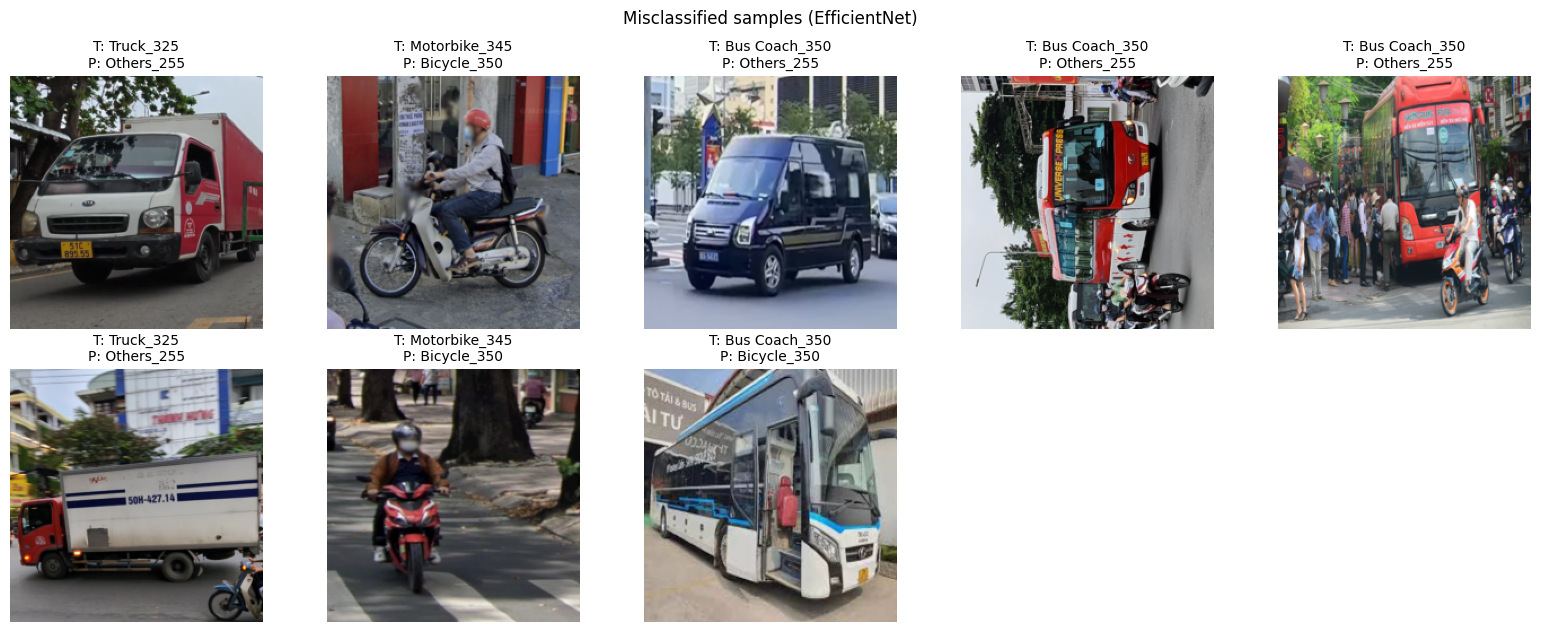


Per-class accuracy (sorted):
- Bus Coach_350: 0.900
- Motorbike_345: 0.909
- Truck_325: 0.920
- Bicycle_350: 1.000
- Car_375: 1.000
- Others_255: 1.000


In [18]:
# =========================
# 8b) Kiểm chứng trực quan: xem ảnh dự đoán đúng/sai trên test set
# =========================
IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T = torch.tensor(IMAGENET_STD).view(3, 1, 1)

def denormalize(img_tensor):
    img = img_tensor.detach().cpu()
    img = img * IMAGENET_STD_T + IMAGENET_MEAN_T
    return torch.clamp(img, 0, 1)

def show_predictions_grid(dataset, indices, y_true, y_pred, class_names, title, max_images=20):
    n = min(max_images, len(indices))
    cols = 5
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 3.2 * rows))
    axes = np.array(axes).reshape(-1)
    for ax in axes[n:]:
        ax.axis('off')

    for i in range(n):
        ds_idx = indices[i]  # index within dataset order
        img, _ = dataset[ds_idx]  # tensor already normalized
        img = denormalize(img)
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0))
        t = class_names[int(y_true[ds_idx])]
        p = class_names[int(y_pred[ds_idx])]
        ax.set_title(f"T: {t}\nP: {p}", fontsize=10)
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Chọn model tốt hơn (không TTA) để kiểm chứng nhanh
model_name = 'EfficientNet' if eff_acc >= res_acc else 'ResNet'
preds = eff_preds if eff_acc >= res_acc else res_preds
print(f"🔎 Visual check model: {model_name}")

# targets/preds đang là theo đúng thứ tự của test_loader (test_dataset)
# Vì test_loader không shuffle, thứ tự là 0..len(test_dataset)-1
y_true_test = targets
y_pred_test = preds

# Lấy danh sách đúng/sai
correct_idx = np.where(y_true_test == y_pred_test)[0]
wrong_idx = np.where(y_true_test != y_pred_test)[0]

print(f"✅ Correct: {len(correct_idx)} / {len(test_dataset)}")
print(f"❌ Wrong:   {len(wrong_idx)} / {len(test_dataset)}")

# Xem một số ảnh dự đoán SAI (quan trọng nhất để biết model đang nhầm gì)
if len(wrong_idx) > 0:
    show_predictions_grid(
        test_dataset,
        wrong_idx.tolist(),
        y_true_test,
        y_pred_test,
        CLASS_NAMES,
        title=f"Misclassified samples ({model_name})",
        max_images=20,
    )
else:
    print('No misclassified samples to display.')

# Per-class accuracy (giúp biết lớp nào khó)
per_class_correct = {c: 0 for c in range(NUM_CLASSES)}
per_class_total = {c: 0 for c in range(NUM_CLASSES)}
for t, p in zip(y_true_test, y_pred_test):
    per_class_total[int(t)] += 1
    per_class_correct[int(t)] += int(t == p)

per_class_acc = {CLASS_NAMES[c]: (per_class_correct[c] / max(1, per_class_total[c])) for c in range(NUM_CLASSES)}
per_class_acc_sorted = sorted(per_class_acc.items(), key=lambda x: x[1])
print('\nPer-class accuracy (sorted):')
for name, acc in per_class_acc_sorted:
    print(f"- {name}: {acc:.3f}")

Saving hundai-1-scaled.jpg to hundai-1-scaled.jpg
✅ Uploaded: hundai-1-scaled.jpg


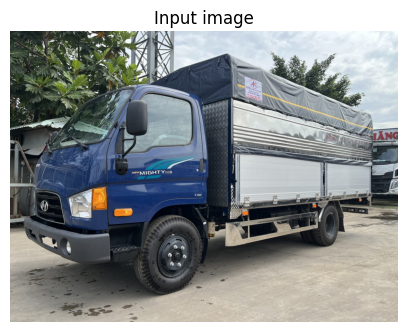

🤖 Model: EfficientNet
🎯 Predicted class: Truck_325  (p=0.932)
Top1: Truck_325 (p=0.932)
Top2: Others_255 (p=0.021)
Top3: Car_375 (p=0.013)
Top4: Motorbike_345 (p=0.013)
Top5: Bus Coach_350 (p=0.011)


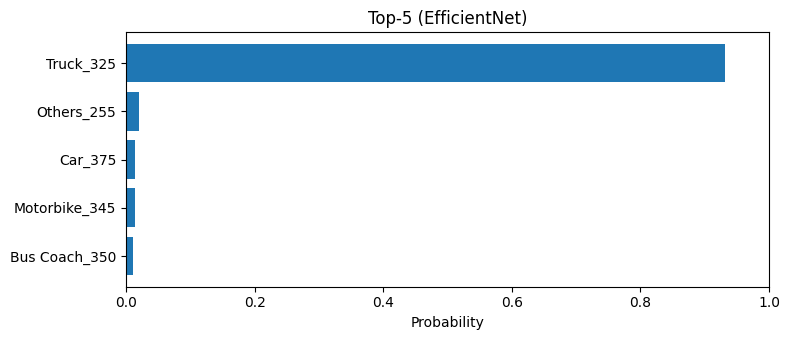

In [19]:
# =========================
# 8c) Upload 1 ảnh và dự đoán lớp phương tiện
# =========================
from PIL import Image

def _pick_inference_model():
    """Chọn model để inference: ưu tiên model có accuracy tốt hơn nếu đã eval."""
    if 'eff_acc' in globals() and 'res_acc' in globals() and 'efficientnet_trained' in globals() and 'resnet_trained' in globals():
        return (efficientnet_trained if eff_acc >= res_acc else resnet_trained), ('EfficientNet' if eff_acc >= res_acc else 'ResNet')
    if 'efficientnet_trained' in globals():
        return efficientnet_trained, 'EfficientNet'
    if 'resnet_trained' in globals():
        return resnet_trained, 'ResNet'
    raise RuntimeError('Chưa có model đã train. Hãy chạy phần Train trước.')

def predict_pil_image(img_pil, model, topk=5):
    model.eval()
    x = eval_transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).detach().cpu()
    k = min(topk, probs.numel())
    top_probs, top_idx = torch.topk(probs, k=k)
    return top_idx.numpy(), top_probs.numpy(), probs.numpy()

def show_topk_bar(class_names, probs, topk=5, title='Top probabilities'):
    k = min(topk, len(class_names))
    idx = np.argsort(probs)[::-1][:k]
    names = [class_names[i] for i in idx][::-1]
    vals = [probs[i] for i in idx][::-1]
    plt.figure(figsize=(8, 0.5 * k + 1))
    plt.barh(names, vals)
    plt.xlim(0, 1)
    plt.title(title)
    plt.xlabel('Probability')
    plt.tight_layout()
    plt.show()

# Upload ảnh từ máy tính lên Colab
try:
    from google.colab import files  # type: ignore
    uploaded = files.upload()
    file_name = next(iter(uploaded.keys()))
    print(f"✅ Uploaded: {file_name}")
    img = Image.open(file_name).convert('RGB')
except Exception as e:
    raise RuntimeError("Cell này dùng cho Google Colab. Nếu bạn không ở Colab, hãy đọc ảnh bằng đường dẫn local.") from e

# Hiển thị ảnh gốc
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Input image')
plt.show()

# Dự đoán
model, model_name = _pick_inference_model()
top_idx, top_probs, probs = predict_pil_image(img, model, topk=5)
pred_class = CLASS_NAMES[int(top_idx[0])]
print(f"🤖 Model: {model_name}")
print(f"🎯 Predicted class: {pred_class}  (p={float(top_probs[0]):.3f})")

# Hiển thị Top-k
for i, (ci, cp) in enumerate(zip(top_idx, top_probs), start=1):
    print(f"Top{i}: {CLASS_NAMES[int(ci)]} (p={float(cp):.3f})")

show_topk_bar(CLASS_NAMES, probs, topk=5, title=f"Top-5 ({model_name})")